In [1]:
DEBUG = True

### Setting up logging

In [2]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("pipeline")

# Show info messages if DEBUG mode is enabled
if DEBUG:
    logger.setLevel(logging.DEBUG)
    logger.debug("DEBUG mode is enabled. Detailed logs will be shown.")
else:
    logger.setLevel(logging.INFO)
    logger.info("DEBUG mode is disabled. Only essential logs will be shown.")

DEBUG:pipeline:DEBUG mode is enabled. Detailed logs will be shown.


# 0. Imports & Configuration

### Imports

In [3]:
import os

# We set up CUDA first to ensure it is configured correctly
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
CUDA_DEVICE = "cuda:0"

In [4]:
from pipeline.proj import load_projection_mat, reformat_sinogram, interpolate_projections, pad_and_reshape, divide_sinogram
from pipeline.aggregate_prj import aggregate_saved_projections
# from .aggregate_ct import aggregate_saved_volumes
# from pipeline.apply_model import apply_model_to_projections, load_model
# from .infer3d import inference_3d
from pipeline.utils import ensure_dir
import torch
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import yaml
import importlib

# TODO run FDK via: FFrecon_reconFDK(input_mat, output_mat); in file "FFrecon_fullFDK.m"
# TODO go through the training code and make sure it is consistent with new pipeline
# TODO add input verification?
# TODO add a way for the user to add more data (since currently if there is any, it will skip the processing entirely)

### Configuration

In [5]:
# Phase of the project (all data, models, etc. will be saved under this phase)
PHASE = "7"

# If this data version already exists in this phase, it will be loaded
# Otherwise it will be created using whatever the most updated data creation script is
DATA_VERSION = '12.2'

# Scans to use for training, val, and testing
SCANS = [
    # (patient_id, scan_id, scan_type, sample)
    # e.g., ("13", "08", "HF", "TRAIN")
    # NOTE: scan_type can only be "HF" or "FF"
    #       and sample can only be "TRAIN", "VALIDATION", or "TEST"
    #       and the patient_id and scan_id should be strings, NOT ints
    ("01", "01", "HF", "TRAIN"),
    ("01", "01", "HF", "VALIDATION"),
    ("02", "01", "FF", "TRAIN"),
]

# List of yaml files that contain configurations for the pipeline
# Each file should contain the paramters for a specific model/ensemble
CONFIG_FILES = [
    "config_TEST.yaml",
]

# Base directory
WORK_ROOT = os.path.abspath("./TESTING")

### Some immediate variable definitions and setting changes based on the configuration...

In [6]:
# Directories derived from bases
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)  # everything should go inside this directory
MODEL_DIR = os.path.join(PHASE_DATAVER_DIR, "model")  # for trained models
RESULT_DIR = os.path.join(PHASE_DATAVER_DIR, "result")  # for outputs of CNN
PROJ_DIR = os.path.join(
    PHASE_DATAVER_DIR, "proj_data"
)  # for input data (gated and non-stop gated projections)
AGG_DIR = os.path.join(
    PHASE_DATAVER_DIR, "agg"
)  # for aggregated data (for PD and ID training)

# Make the folders if they don't already exist
ensure_dir(PHASE_DATAVER_DIR)
ensure_dir(MODEL_DIR)
ensure_dir(RESULT_DIR)
ensure_dir(PROJ_DIR)
ensure_dir(AGG_DIR)

logger.debug("All directories are set up successfully.")

DEBUG:pipeline:All directories are set up successfully.


# 1. Data Preparation: projection interpolation

In [7]:
# Only process the data if it doesn't already exist
if len(os.listdir(PROJ_DIR)) > 0:
    logger.info(f"Projection data for phase {PHASE} data version {DATA_VERSION} already exists in {PROJ_DIR}. Skipping processing.")
else:
    logger.info("Starting to process projection data...")
    for patient, scan, scan_type, sample in SCANS:
        # Load the projection data from the matlab files
        odd_index, angles, prj = load_projection_mat(patient, scan, scan_type, WORK_ROOT)

        # Log shapes of loaded data
        logger.debug(f'Processing patient {patient}, scan {scan}, type {scan_type}, sample {sample}')
        logger.debug(f'Loaded odd_index shape: {odd_index.shape}')
        logger.debug(f'Loaded angles shape: {angles.shape}')
        logger.debug(f'Loaded projection shape: {prj.shape}')

        # Flip and permute to get it in the right format
        prj_gcbct, angles1 = reformat_sinogram(prj, angles)

        # Log shapes after reformatting
        logger.debug(f'Reformatted projection shape: {prj_gcbct.shape}')

        # Simulate ngCBCT projections
        prj_ngcbct_li = interpolate_projections(prj_gcbct, odd_index)

        # Log shapes after interpolation
        logger.debug(f'Interpolated ngCBCT projection shape: {prj_ngcbct_li.shape}')

        # Split the projections into two halves so they are good dimensions for the CNN
        combined_gcbct = divide_sinogram(pad_and_reshape(prj_gcbct), v_dim=512 if scan_type == "HF" else 256)
        combined_ngcbct = divide_sinogram(pad_and_reshape(prj_ngcbct_li), v_dim=512 if scan_type == "HF" else 256)

        # Log shapes after dividing sinograms
        logger.debug(f'Combined gCBCT shape: {combined_gcbct.shape}')
        logger.debug(f'Combined ngCBCT shape: {combined_ngcbct.shape}')

        # Ensure the output directories exist
        g_dir = os.path.join(PROJ_DIR, 'gated')
        ng_dir = os.path.join(PROJ_DIR, 'ng')
        ensure_dir(g_dir)
        ensure_dir(ng_dir)

        logger.debug(f'Saving projections...')
        
        # Save the projections
        # NOTE: These need to have the same name since later we will aggregate them, and we just sort by the name
        torch.save(combined_gcbct, os.path.join(g_dir, f'{scan_type}_p{patient}_{scan}_{sample}.pt')) # e.g., HF_p01_01_TRAIN.pt
        torch.save(combined_ngcbct, os.path.join(ng_dir, f'{scan_type}_p{patient}_{scan}_{sample}.pt'))

        logger.debug(f'Done with patient {patient}, scan {scan}, type {scan_type}, sample {sample}\n')

    logger.info("All projections saved successfully.")
    logger.info("Gated projections saved in: %s", g_dir)
    logger.info("Nonstop-gated projections saved in: %s", ng_dir)

    # Free up memory
    del odd_index, angles, prj, prj_gcbct, angles1, prj_ngcbct_li, combined_gcbct, combined_ngcbct

INFO:pipeline:Projection data for phase 7 data version 12.2 already exists in /Users/noahsilverberg/Documents/MSK-Research/ngCBCT/TESTING/phase7/DS12.2/proj_data. Skipping processing.


### DEBUG: Sample projections

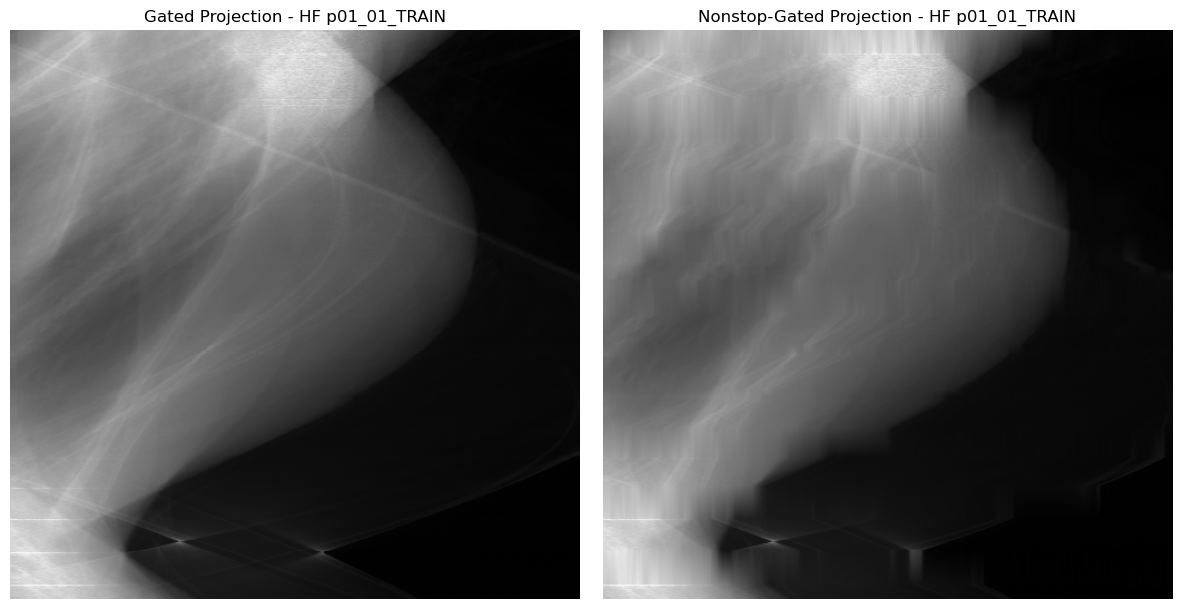

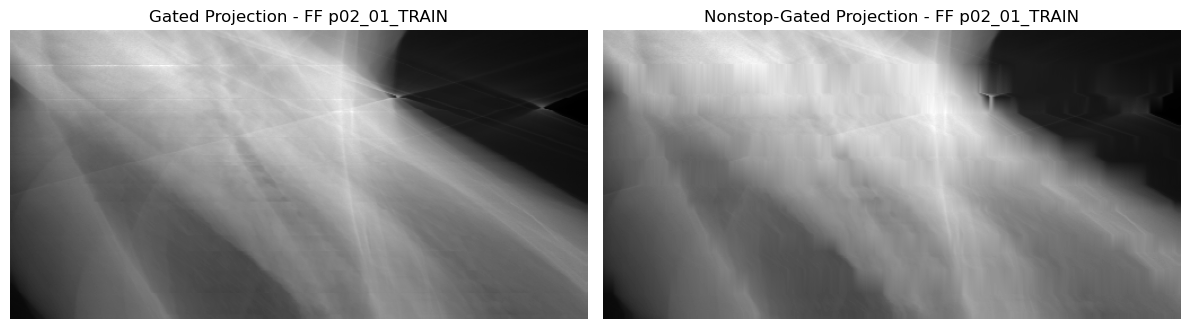

In [8]:
if DEBUG:
    # Pick the first HF scan and first FF scan
    for patient, scan, scan_type, sample in SCANS:
        if scan_type == "HF":
            hf_scan = (patient, scan, scan_type, sample)
            break
    for patient, scan, scan_type, sample in SCANS:
        if scan_type == "FF":
            ff_scan = (patient, scan, scan_type, sample)
            break

    g_dir = os.path.join(PROJ_DIR, 'gated')
    ng_dir = os.path.join(PROJ_DIR, 'ng')

    # Display the first HF scan
    # Show the gated and nonstop-gated on subplots
    hf_patient, hf_scan_num, hf_scan_type, hf_sample = hf_scan
    hf_gated_prj = torch.load(os.path.join(g_dir, f'{hf_scan_type}_p{hf_patient}_{hf_scan_num}_{hf_sample}.pt'))
    hf_ng_prj = torch.load(os.path.join(ng_dir, f'{hf_scan_type}_p{hf_patient}_{hf_scan_num}_{hf_sample}.pt'))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(hf_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}_{hf_sample}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(hf_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Nonstop-Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}_{hf_sample}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Repeat for FF scan
    ff_patient, ff_scan_num, ff_scan_type, ff_sample = ff_scan
    ff_gated_prj = torch.load(os.path.join(g_dir, f'{ff_scan_type}_p{ff_patient}_{ff_scan_num}_{ff_sample}.pt'))
    ff_ng_prj = torch.load(os.path.join(ng_dir, f'{ff_scan_type}_p{ff_patient}_{ff_scan_num}_{ff_sample}.pt'))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(ff_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}_{ff_sample}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(ff_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Nonstop-Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}_{ff_sample}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Free up memory
    del hf_gated_prj, hf_ng_prj, ff_gated_prj, ff_ng_prj

# 2. Aggregate projections for train/val/test

In [9]:
# Only aggregate projections if they don't already exist
if len([f for f in os.listdir(AGG_DIR) if f.startswith("PROJ")]) > 0:
    logger.info(f"Aggregated projection data for phase {PHASE} data version {DATA_VERSION} already exists in {AGG_DIR}. Skipping aggregation.")
else:
    logger.info("Starting to aggregate projection data...")
    # Aggregate and save projection data sets
    for scan_type in ['HF', 'FF']:
        for sample in ['TRAIN', 'VALIDATION', 'TEST']:
            try:
                prj_gcbct, prj_ngcbct = aggregate_saved_projections(scan_type, sample, PROJ_DIR)
                np.save(os.path.join(AGG_DIR, f"PROJ_gated_{scan_type}_{sample}.npy"), prj_gcbct.cpu().numpy()) # e.g., PROJ_gated_HF_TRAIN.npy
                np.save(os.path.join(AGG_DIR, f"PROJ_ng_{scan_type}_{sample}.npy"), prj_ngcbct.cpu().numpy())
            except Exception as e:
                logger.error(str(e) + '\n')
                continue

            logger.debug(f"Aggregated projections saved for {scan_type} {sample}.\n")

    # Free up memory
    del prj_gcbct, prj_ngcbct

INFO:pipeline:Aggregated projection data for phase 7 data version 12.2 already exists in /Users/noahsilverberg/Documents/MSK-Research/ngCBCT/TESTING/phase7/DS12.2/agg. Skipping aggregation.


# 3. Training PD CNN

In [11]:
for config_file in CONFIG_FILES:
    # Load the yaml configuration file
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
    
    logger.debug(f"Loaded configuration from {config_file}")

    # Skip this config if the user has set PD_training to False
    if not config['PD_settings']['training']:
        logger.info(f"Skipping PD training for {config_file} as PD training is set to False.")
        continue

    # Get the training application
    module_name, class_name = config['PD_settings']['training_app'].rsplit('.', 1)
    module = importlib.import_module("pipeline." + module_name)
    cls = getattr(module, class_name)

    logger.debug(f"Loaded class {class_name} from module {module_name}")

    # Get the ensemble size, and loop through it
    ensemble_size = config['PD_settings']['ensemble_size']
    for i in range(ensemble_size):
        # If we are training an ensemble, we add an identifier to the model version
        if ensemble_size > 1:
            config['PD_settings']['model_version'] += f"_{i + 1:02}"  # e.g., "v1_01"

        # Instantiate with the loaded configuration
        instance = cls(config, "PROJ", DEBUG, MODEL_DIR, AGG_DIR)

        logger.info(f"Going to try training the {i + 1}-th model with configuration from {config_file}...")

        # Run the training
        instance.main()

        logger.info(f"Finished training the {i + 1}-th model.\n")

    # Free up memory
    del module, cls, instance, config, module_name, class_name

DEBUG:pipeline:Loaded configuration from config_TEST.yaml
DEBUG:pipeline:Loaded class TrainingApp from module train_app_MK6_numpy
INFO:pipeline:Going to try training the 1-th model with configuration from config_TEST.yaml...
DEBUG:pipeline:Starting TrainingApp, {'training': True, 'training_app': 'train_app_MK6_numpy.TrainingApp', 'epochs': 5, 'learning_rate': 0.001, 'network_name': 'DummyNet', 'model_version': 'MK6', 'batch_size': 8, 'optimizer': 'NAdam', 'num_workers': 0, 'shuffle': True, 'grad_clip': True, 'grad_max': 0.01, 'betas_NAdam': (0.9, 0.999), 'momentum_decay_NAdam': 0.0004, 'momentum_SGD': 0.99, 'weight_decay_SGD': 1e-08, 'checkpoint_save_step': 2, 'tensor_board': False, 'tensor_board_comment': '', 'train_during_inference': False, 'ensemble_size': 1, 'scan_type': 'HF', 'augment': None, 'input_type': None, 'domain': 'PROJ', 'MODEL_DIR': '/Users/noahsilverberg/Documents/MSK-Research/ngCBCT/TESTING/phase7/DS12.2/model', 'AGG_DIR': '/Users/noahsilverberg/Documents/MSK-Research/

# 4. Apply PD model to all nonstop-gated sinograms

In [ ]:
# Load the trained PD model onto the GPU
PD_model = load_model(PD_network_name, PD_model_name, device=torch.device(CUDA_DEVICE))

for patient, scan, scan_type, sample in SCANS:
    # Get the matlab dicts for the ground truth and CNN projections
    g_mat, cnn_mat = apply_model_to_projections(patient, scan, scan_type, sample, PD_model)

    # Save the ground truth and CNN projections
    scipy.io.savemat(os.path.join(RESULT_DIR, f'PROJ_gated_{scan_type}_p{patient}_{scan}_{sample}.mat'), g_mat) # e.g., PROJ_gated_HF_p01_01_TRAIN.mat
    scipy.io.savemat(os.path.join(RESULT_DIR, f'PROJ_ng_{scan_type}_p{patient}_{scan}_{sample}.mat'), cnn_mat)

# Free up memory
del PD_model, g_mat, cnn_mat

# 5. TODO: FDK

In [ ]:
# TODO

# 6. Aggregate CT volumes for train/val/test

In [ ]:
# Directory for aggregated data saving
vol_agg_dir = os.path.join(DATA_DIR, "agg", "volumes")
ensure_dir(vol_agg_dir)

# Aggregate and save volume data sets
for scan_type in ['HF', 'FF']:
    for sample in ['train', 'validation', 'test']:
        vol_gcbct, vol_ngcbct = aggregate_saved_volumes(scan_type, sample)
        torch.save(vol_gcbct, os.path.join(vol_agg_dir, f"{scan_type}_{sample}_gated.pt"))
        torch.save(vol_ngcbct, os.path.join(vol_agg_dir, f"{scan_type}_{sample}_ng.pt"))

# Free up memory
del vol_gcbct, vol_ngcbct

# 7. Train ID CNN

In [ ]:
# TODO

# 8. Inference on test scans for full 3D

In [ ]:
vol = inference_3d(patient_id, scan_id, 'HF', data_version, model_name, 'tumor_location_panc.pt')